In [6]:
# Import important libraries here

import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import json
import math

Using cache found in C:\Users\Vardhan Mistry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-4-20 Python-3.12.2 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


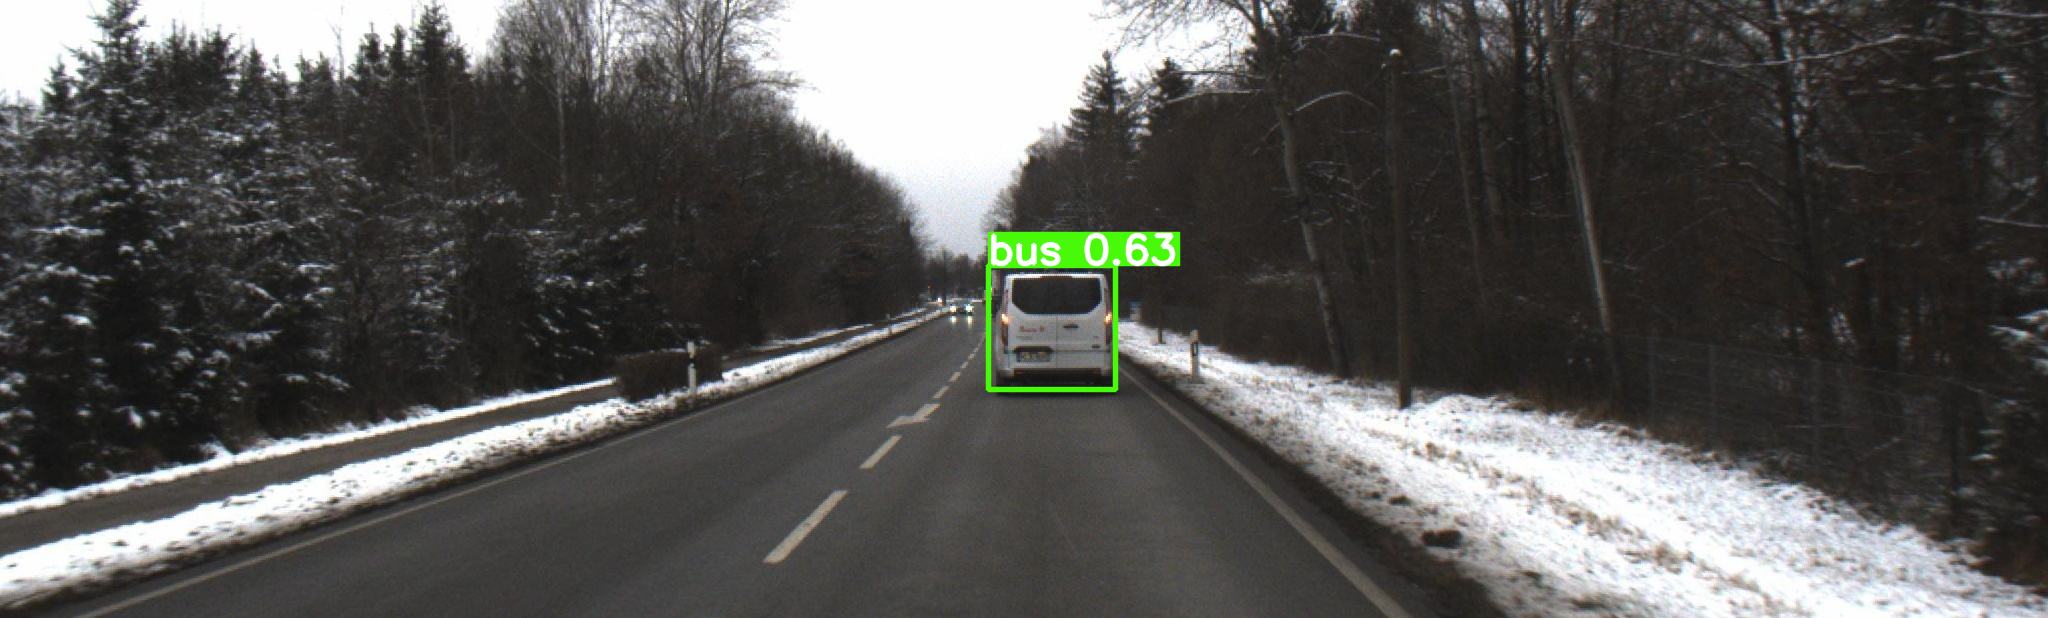

In [10]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg']  # batch of images

# Inference
results = model(imgs)

# Show detected objects
results.show()
results.xyxy[0]  # img1 predictions (tensor)
df = results.pandas().xyxy[0]

# Define output path
output_path = './dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000131.csv'

# Save DataFrame to CSV
df.to_csv(output_path, index=False)


In [11]:
class calib_astyx():
    def __init__(self, file):
        # Initialize the calibration object by loading sensor calibration data from a JSON file.
        # Parameters:
        # - file: A string path to the JSON file containing calibration data for radar, lidar, and camera sensors.

        # Load calibration data from a JSON file
        with open(file) as json_file:
            data = json.load(json_file)
            
        # Calibration matrices for converting radar, lidar, and camera data to a reference coordinate system
        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])  # Radar to reference
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])  # Lidar to reference (COS means Coordinate System)
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])  # Camera to reference
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])  # Intrinsic camera matrix
        
        # Compute inverse transformations for mapping from the reference coordinate system back to sensor-specific coordinate systems
        self.ref2radar = self.inv_trans(self.radar2ref)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        # Compute the inverse transformation matrix for a given sensor to reference coordinate transformation.
        # Parameters:
        # - T: A numpy array representing the transformation matrix from sensor to reference coordinates.
        # Returns:
        # - The inverse transformation matrix as a numpy array, which can be used to map points from the
        # reference coordinate system back to the sensor-specific coordinate system.

        rotation = np.linalg.inv(T[0:3, 0:3])  # Invert the rotation part
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)  # Invert the translation part
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))  # Reassemble the inverted transformation matrix

        return Q

    def lidar2ref(self, points):
        # Convert lidar points from the lidar coordinate system to the reference coordinate system.
        # Parameters:
        # - points: A numpy array of points in the lidar coordinate system.
        # Returns:
        # - A numpy array of the same points transformed to the reference coordinate system.

        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate

    def ref2Camera(self, points, img_size):
        # Project points from the reference coordinate system onto the camera image plane.
        # Parameters:
        # - points: A numpy array of points in the reference coordinate system.
        # - img_size: A tuple representing the size of the camera image (width, height).
        # Returns:
        # - A tuple containing a numpy array of the projected points on the camera image plane and a mask
        # array indicating which points are within the image frame.

        obj_image = np.dot(self.ref2camera[0:3, 0:3], points.T)  # Apply rotation
        T = self.ref2camera[0:3, 3]
        obj_image = obj_image + T[:, np.newaxis]  # Apply translation
        obj_image = np.dot(self.K, obj_image)  # Apply intrinsic camera matrix
        obj_image = obj_image / obj_image[2]  # Normalize by the third row to project onto image plane
        obj_image = np.delete(obj_image, 2, 0)  # Remove the third row
        
        # Create a mask to filter out points that are outside the image frame or behind the camera
        mask = (obj_image[0,:] <= img_size[0]) & \
               (obj_image[1,:] <= img_size[1]) & \
               (obj_image[0,:] >= 0) & (obj_image[1,:] >= 0) & \
               (points[:,0] >= 0)
        return obj_image, mask  # Return the projected points and the mask


In [12]:


class Object3d(object):
    """
    Represents a 3D object with attributes extracted from a given input dictionary.
    This class handles the extraction and manipulation of various object properties,
    including its orientation, bounding box, and angle calculations based on quaternion
    orientation data.

    Attributes:
    - type (str): The class name of the object.
    - occlusion (float): The occlusion level of the object.
    - quat (numpy.ndarray): Quaternion representing the object's orientation.
    - rotationmatrix (numpy.ndarray): Rotation matrix derived from the quaternion.
    - h (float): Height of the object's bounding box.
    - w (float): Width of the object's bounding box.
    - l (float): Length of the object's bounding box.
    - t (tuple): A tuple representing the center of the object's bounding box.
    - distance (float): Distance of the object from the origin, calculated using its bounding box center.
    - bbox (numpy.ndarray): Coordinates of the object's bounding box corners.
    - angle (float): Angle of the object's orientation in degrees.
    """
    def __init__(self, obj):
        """
        Initializes an Object3d instance by extracting relevant attributes from the input dictionary.

        Parameters:
        - obj (dict): A dictionary containing object properties, including its class name,
                      dimensions, center, occlusion level, and orientation quaternion.
        """
        # Extract basic attributes
        self.type = obj["classname"]
        self.occlusion = obj["occlusion"] 
        self.quat = np.array(obj["orientation_quat"])
        self.rotationmatrix = self.get_rotationmatrix()
        
        # Extract 3D bounding box information
        self.h = obj["dimension3d"][2]  # box height
        self.w = obj["dimension3d"][1]  # box width
        self.l = obj["dimension3d"][0]  # box length (in meters)
        self.t = (obj["center3d"][0], obj["center3d"][1], obj["center3d"][2])
        
        self.distance = np.sqrt(np.sum(np.square(self.t)))
        
        # Calculate bounding box corners and object's angle
        self.bbox = self.get_bbox()
        self.angle = self.get_angle()[2]
        if self.angle >= 0:
            self.angle = self.angle * 180 / np.pi
        else:
            self.angle = self.angle * 180 / np.pi + 360

    def get_angle(self):
        """
        Calculates the Euler angles from the object's orientation quaternion.

        Returns:
        - A tuple of Euler angles (roll, pitch, yaw) in radians.
        """
        w, x, y, z = self.quat
        return (math.atan2(2*(w*x+y*z), 1-2*(x*x+y*y)),
                math.asin(2*(w*y-z*x)),
                math.atan2(2*(w*z+x*y), 1-2*(y*y+z*z)))

    def get_bbox(self):
        """
        Calculates the coordinates of the object's bounding box corners based on its
        center, dimensions, and orientation.

        Returns:
        - A numpy.ndarray containing the coordinates of the bounding box corners.
        """
        center = np.array(self.t)
        dimension = np.array([self.l, self.w, self.h])

        # Adjust dimensions for bounding box calculation
        w, l, h = dimension[0] + 0.1, dimension[1] + 0.1, dimension[2]

        # Define corner points in local object coordinates
        x_corners = [-w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2]
        y_corners = [l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2]
        z_corners = [h / 2, h / 2, h / 2, -h / 2, -h / 2, -h / 2, -h / 2, h / 2]

        # Apply rotation and translate to global coordinates
        R = self.rotationmatrix
        bbox = np.vstack([x_corners, y_corners, z_corners])
        bbox = np.dot(R, bbox)
        bbox = bbox + center[:, np.newaxis]
        bbox = np.transpose(bbox)

        return bbox
    
    def get_rotationmatrix(self):
        """
        Converts the object's orientation quaternion into a rotation matrix.

        Returns:
        - A numpy.ndarray representing the rotation matrix.
        """
        n = np.dot(self.quat, self.quat)
        if n < np.finfo(self.quat.dtype).eps:
            return np.identity(4)  # Return identity matrix if quaternion is near zero
        
        q = self.quat * np.sqrt(2.0 / n)
        q = np.outer(q, q)
        rot_matrix = np.array(
            [[1.0 - q[2, 2] - q[3, 3], q[1, 2] + q[3, 0], q[1, 3] - q[2, 0]],
             [q[1, 2] - q[3, 0], 1.0 - q[1, 1] - q[3, 3], q[2, 3] + q[1, 0]],
             [q[1, 3] + q[2, 0], q[2, 3] - q[1, 0], 1.0 - q[1, 1] - q[2, 2]]],
            dtype=q.dtype)
        rot_matrix = np.transpose(rot_matrix)
        return rot_matrix

class calib_astyx():
    """
    This class is designed to manage the calibration of sensor data in autonomous vehicle contexts.
    
    It supports the conversion of sensor data between different coordinate systems, specifically for radar,
    lidar, and camera sensors, to a common reference coordinate system and vice versa. It also handles the
    projection of points from the reference coordinate system onto the camera image plane.
    """
    
    def __init__(self, file):
        """
        Initialize the calibration object by loading sensor calibration data from a JSON file.
        
        Parameters:
        - file: A string path to the JSON file containing calibration data for radar, lidar, and camera sensors.
        
        The method extracts transformation matrices for each sensor to the reference coordinate system and
        the intrinsic camera matrix.
        """
        # Load calibration data from a JSON file
        with open(file) as json_file:
            data = json.load(json_file)
            
        # Calibration matrices for converting radar, lidar, and camera data to a reference coordinate system
        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])  # Radar to reference
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])  # Lidar to reference (COS means Coordinate System)
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])  # Camera to reference
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])  # Intrinsic camera matrix
        
        # Compute inverse transformations for mapping from the reference coordinate system back to sensor-specific coordinate systems
        self.ref2radar = self.inv_trans(self.radar2ref)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        """
        Compute the inverse transformation matrix for a given sensor to reference coordinate transformation.
        
        Parameters:
        - T: A numpy array representing the transformation matrix from sensor to reference coordinates.
        
        Returns:
        - The inverse transformation matrix as a numpy array, which can be used to map points from the
          reference coordinate system back to the sensor-specific coordinate system.
        """
        rotation = np.linalg.inv(T[0:3, 0:3])  # Invert the rotation part
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)  # Invert the translation part
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))  # Reassemble the inverted transformation matrix

        return Q
    
    def lidar2ref(self, points):
        """
        Convert lidar points from the lidar coordinate system to the reference coordinate system.
        
        Parameters:
        - points: A numpy array of points in the lidar coordinate system.
        
        Returns:
        - A numpy array of the same points transformed to the reference coordinate system.
        """
        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate

    def ref2Camera(self, points, img_size):
        """
        Project points from the reference coordinate system onto the camera image plane.
        
        Parameters:
        - points: A numpy array of points in the reference coordinate system.
        - img_size: A tuple representing the size of the camera image (width, height).
        
        Returns:
        - A numpy array of projected points on the camera image plane.
        - A boolean mask indicating whether each point is visible in the camera image.
        """
        n = points.shape[0]
        
        # Convert points to homogeneous coordinates
        points_hom = np.hstack((points, np.ones((n,1))))
        
        # Transform points to camera coordinate system
        points_camera = np.dot(points_hom, np.transpose(self.ref2camera))
        
        # Project points onto camera image plane
        projected_points = np.dot(points_camera, np.transpose(self.K))
        projected_points = projected_points[:, 0:2] / projected_points[:, 2][:, None]
        
        # Create mask to filter out points outside the image boundaries
        mask = (projected_points[:, 0] >= 0) & (projected_points[:, 0] < img_size[0]) & \
               (projected_points[:, 1] >= 0) & (projected_points[:, 1] < img_size[1])
        
        return projected_points, mask


In [14]:
# Load calibration data
calib = calib_astyx("./dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/000131.json")

# Load lidar data from text file
lidar = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt", skiprows=1)

lidar_points = lidar[:, :3]  # Selecting only the first three points
lidar_points_ref = calib.lidar2ref(lidar_points)


# Load camera image using OpenCV
img = cv2.imread("./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg")  

# Get the height and width of the image
img_height, img_width = img.shape[:2]

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(lidar_points_ref, (img_width, img_height))



In [15]:
# Convert projected points to integers for pixel coordinates
projected_points_int = projected_points.astype(int)

# Draw projected lidar points on the image
# Draw projected lidar points on the image
for point in projected_points_int:
    cv2.circle(img, (point[0], point[1]), radius=3, color=(0, 255, 0), thickness=-1)


# Show the image with projected lidar points
cv2.imshow("Projected Lidar Points", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Radar Points